# Padova Demo

Padova provides pythonic access to Padova group's stellar isochrone web app, [CMD](http://stev.oapd.inaf.it/cgi-bin/cmd). This notebook will briefly show you what Padova can do. First, some setup for this notebook:

In [16]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import numpy as np

In [17]:
%%bash
pip install git+git://github.com/jradavenport/cubehelix.git

Downloading/unpacking git+git://github.com/jradavenport/cubehelix.git
  Cloning git://github.com/jradavenport/cubehelix.git to /var/folders/dk/gqvjktxj0mzgbqc91gjrg3_00000gn/T/pip-kuw8Zz-build
  Running setup.py (path:/var/folders/dk/gqvjktxj0mzgbqc91gjrg3_00000gn/T/pip-kuw8Zz-build/setup.py) egg_info for package from git+git://github.com/jradavenport/cubehelix.git
    
Cleaning up...


****

## Intro

Padova provides three classes tailored to the types of isochrone queries you want to make.

- `IsochroneRequest` will query for a single isochrone
- `AgeGridRequest` will query for a set of isochrones with a single metallicity for a grid of ages
- `MetallicityGridRequest` will query for a set of isochrones with a single age, for a grid of metallicities.

In [18]:
from padova import IsochroneRequest, AgeGridRequest, MetallicityGridRequest

## Single isochrone requests

To obtain a single isochrone for a speific age and metallicity we'll create a `IsochroneRequest` instance and pass the stellar population settings: the age as $\log (A/\mathrm{yr})$, metallicity as a fraction the composition. We also specify the photometric system, (WFC3 filters). Since WFC3 isn't supported by the latest bolometric correction library, we use the older Girardi et al 2008 specification (`'odfnew'`).

In [19]:
r = IsochroneRequest(log_age=9, z=0.02, phot='wfc3', photsys_version='odfnew')

Reading from cache


Now that the request has been computed and downloaded from the CMD API, we can inspect the isochrones. First, we can look at the raw result:

In [20]:
r.data

'# File generated by CMD 2.7 (http://stev.oapd.inaf.it/cmd) on Thu Apr  9 23:33:13 CEST 2015\n# PARSEC isochrones, release v1.2S\n# Basic references: Bressan et al. (2012), MNRAS, 427, 127 + Chen et al. (2014), MNRAS, 444, 2525 + Tang et al. (2014), MNRAS, 445, 4287\n# Warning: the TP-AGB phase is not included! TP-AGB tracks are in preparation by Marigo et al.\n# Photometric system: \n# BCs of Carbon stars derive from Aringer et al. (2009, A&A 503, 913)\n# O-rich circumstellar dpmod60alox40 dust from Groenewegen (2006)\n# C-rich circumstellar AMCSIC15 dust from Groenewegen (2006)\n# IMF: Chabrier (2001) lognormal \n# On RGB, assumed Reimers mass loss with efficiency eta=0.2\n# Kind of output: isochrone tables\n#\tIsochrone  Z = 0.02000\tY = 0.28400\t[M/H] = 0.142\teta_R = 0.200\tAge = \t1.0000e+09 yr\n#      Z\tlog(age/yr)\tM_ini   \tM_act\tlogL/Lo\tlogTe\tlogG\tmbol    F200LP1 F218W1  F225W1  F275W1  F336W   F350LP  F390W   F438W   F475W   F555W   F600LP  F606W   F625W   F775W   F814W

The Padova package parses this result into Astropy-compatible tables. You can access the isochrone table with `isochone` attribute.

In [21]:
isoc = r.isochrone
print("Isochrone of Z={0:.2f}, age={0:.3e}".format(isoc.z, isoc.age))
print("Available filters: {0}".format(" ".join(isoc.filter_names)))
print(isoc.meta)
print(isoc)

Isochrone of Z=0.02, age=2.000e-02
Available filters: F200LP1 F218W1 F225W1 F275W1 F336W F350LP F390W F438W F475W F555W F600LP F606W F625W F775W F814W F850LP F105W F110W F125W F140W F160W
OrderedDict([('Z', 0.02), ('Y', 0.284), ('[M/H]', 0.142), ('eta_R', 0.2), ('Age', 1000000000.0), ('header', ['File generated by CMD 2.7 (http://stev.oapd.inaf.it/cmd) on Thu Apr  9 23:33:13 CEST 2015', 'PARSEC isochrones, release v1.2S', 'Basic references: Bressan et al. (2012), MNRAS, 427, 127 + Chen et al. (2014), MNRAS, 444, 2525 + Tang et al. (2014), MNRAS, 445, 4287', 'Warning: the TP-AGB phase is not included! TP-AGB tracks are in preparation by Marigo et al.', 'Photometric system:', 'BCs of Carbon stars derive from Aringer et al. (2009, A&A 503, 913)', 'O-rich circumstellar dpmod60alox40 dust from Groenewegen (2006)', 'C-rich circumstellar AMCSIC15 dust from Groenewegen (2006)', 'IMF: Chabrier (2001) lognormal', 'On RGB, assumed Reimers mass loss with efficiency eta=0.2', 'Kind of output: isoch

We can plot up the isochrones as if they were in a nearby galaxy:

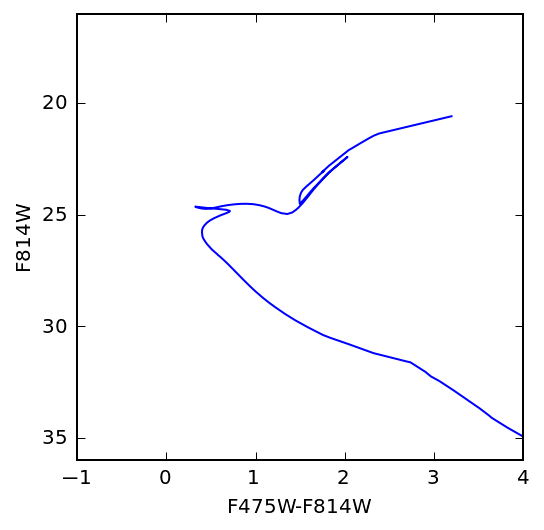

In [22]:
from astropy.coordinates import Distance
import astropy.units as u
import matplotlib.pyplot as plt
import matplotlib as mpl

fig = plt.figure(figsize=(4, 4), dpi=300)
gs = mpl.gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0])

d = Distance(785 * u.kpc)
ax.plot(isoc['F475W'] - isoc['F814W'], isoc['F814W'] + d.distmod.value)
ax.set_xlim(-1, 4.)
ax.set_ylim(36., 16.)
ax.set_xlabel("F475W-F814W")
ax.set_ylabel("F814W")
fig.show()

## Requesting isochrones for a grid of ages

Rather than repeatedly calling the CMD server to generate isochrones over a grid, we can generate age or metallicity grids in one call. Here we'll request a set of isochrones spanning a grid of ages, for a single metallicity.

In [23]:
r2 = AgeGridRequest(z=0.02,
                    min_log_age=7., max_log_age=10.1, log_age_delta=0.1,
                    phot='wfc3', photsys_version='odfnew')

Reading from cache


In [24]:
r2_isochrones = r2.isochrone_set

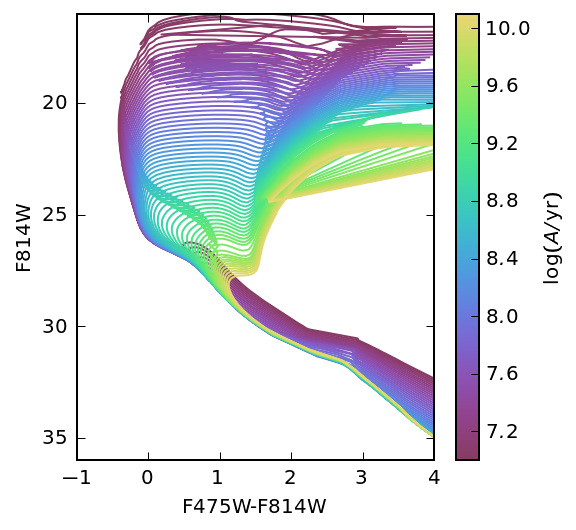

In [25]:
import cubehelix
from astropy.coordinates import Distance
import astropy.units as u
import matplotlib.pyplot as plt
import matplotlib as mpl

fig = plt.figure(figsize=(4, 4), dpi=300)
gs = mpl.gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0])

cmap = cubehelix.cmap(startHue=240, endHue=-300, minSat=1, maxSat=2.5, minLight=.3, maxLight=.8, gamma=.9)
scalar_map = mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=7., vmax=10.1),
                                   cmap=cmap)
scalar_map.set_array(np.array([isoc.age for isoc in r2_isochrones]))

d = Distance(785 * u.kpc)
for isoc in r2_isochrones:
    ax.plot(isoc['F475W'] - isoc['F814W'], isoc['F814W'] + d.distmod.value,
            c=scalar_map.to_rgba(np.log10(isoc.age)))
cb = plt.colorbar(mappable=scalar_map, cax=None, ax=ax)
cb.set_label(r"$\log(A/\mathrm{yr})$")
ax.set_xlim(-1, 4.)
ax.set_ylim(36., 16.)
ax.set_xlabel("F475W-F814W")
ax.set_ylabel("F814W")
fig.show()

## Requesting isochrones for a grid of metallicities

This request behaves similarly to the age grid. Here's a complete demonstration:

In [26]:
r3 = MetallicityGridRequest(log_age=9., min_z=0.0001, max_z=0.03, delta_z=0.001,
                            phot='wfc3', photsys_version='odfnew')
r3_isochrones = r3.isochrone_set

Reading from cache


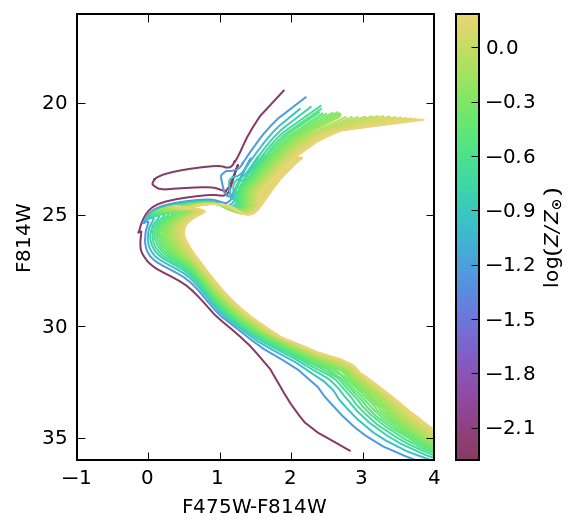

In [27]:
import cubehelix
from astropy.coordinates import Distance
import astropy.units as u
import matplotlib.pyplot as plt
import matplotlib as mpl

fig = plt.figure(figsize=(4, 4), dpi=300)
gs = mpl.gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0])

scale_z = lambda z: np.log10(z / 0.019)
z_values = np.array([scale_z(isoc.z) for isoc in r3_isochrones])

cmap = cubehelix.cmap(startHue=240, endHue=-300, minSat=1, maxSat=2.5, minLight=.3, maxLight=.8, gamma=.9)
scalar_map = mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=z_values.min(), vmax=z_values.max()),
                                   cmap=cmap)
scalar_map.set_array(z_values)

d = Distance(785 * u.kpc)
for isoc in r3_isochrones:
    ax.plot(isoc['F475W'] - isoc['F814W'], isoc['F814W'] + d.distmod.value,
            c=scalar_map.to_rgba(scale_z(isoc.z)))
cb = plt.colorbar(mappable=scalar_map, cax=None, ax=ax)
cb.set_label(r"$\log(Z/Z_\odot)$")
ax.set_xlim(-1, 4.)
ax.set_ylim(36., 16.)
ax.set_xlabel("F475W-F814W")
ax.set_ylabel("F814W")
fig.show()

## Caching

Padova caches all results from the CMD web application. This means that you can repeatedly test and run your code without hammering the CMD servers, or experiencing any lag. Each request instance has a hash generated from the complete parameter set (including defaults):

In [28]:
r.__hash__()

'f73fe412c59883cbe04cee3bf80501d6'

We can verify that the request we just made has been cached:

In [29]:
from padova.resultcache import PadovaCache
cache = PadovaCache()
r.__hash__() in cache

True

Note that by default the cache files are located in `~/.padova_cache`.

## Exporting Isochrones to StarFISH

StarFISH is a Hess diagram simulation and fitting tool by Harris and Zaritsky. Padova can export isochrones into the format expected by StarFISH.

In [30]:
isoc.export_for_starfish("here")